In [251]:
import sys  
sys.path.insert(0, './machine_learning_models')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
from sklearn.metrics import confusion_matrix, accuracy_score
import pickle
from IPython.display import clear_output
from itertools import product, combinations
import json
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, log_loss, brier_score_loss, classification_report
from sklearn.feature_selection import RFE
pd.set_option('mode.chained_assignment', None)

In [217]:
first_season = 2012
last_season = 2022

season_file = f'{first_season}-{last_season}'

min_threshold = 1.75
max_threshold = 10

first_attr_index = 6
target_index = -3

# default_stake = 50
bankroll = 2000
stake = 0.025

In [218]:
print('\nGetting data for the model...')

dataset = pd.read_csv('./data/{}.csv'.format(season_file), index_col = 0)
dataset = dataset.loc[(dataset['ODDS_A'].notna()) & (dataset['ODDS_B'].notna())]
dataset['GAME_DATE'] = pd.to_datetime(dataset['GAME_DATE']).dt.date


Getting data for the model...


In [219]:
dataset

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,WINNER,GAME_PTS_A,GAME_PTS_B
0,2012,2012-11-17,PHX,MIA,3.20,1.36,99.3,105.0,0.4307,0.3241,...,1.0,0.500,-1,0.7,0.6,111.655660,107.418542,A,88,97
1,2012,2012-11-18,DET,BOS,2.46,1.56,93.0,99.8,0.4378,0.3553,...,0.0,0.600,-1,0.6,0.6,105.807366,104.982441,H,103,83
2,2012,2012-11-19,DAL,GSW,1.16,5.34,100.9,100.1,0.4627,0.3893,...,0.0,0.500,-1,0.5,0.4,100.099647,102.401857,A,101,105
3,2012,2012-11-19,UTA,HOU,1.33,3.37,96.2,97.8,0.4370,0.3231,...,0.0,0.400,-2,0.4,0.4,102.150776,102.700599,H,102,91
4,2012,2012-11-20,PHI,TOR,1.45,2.77,88.9,90.1,0.4109,0.4000,...,0.0,0.200,-1,0.3,0.2,100.874199,104.481087,H,106,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11485,2022,2023-04-09,OKC,MEM,1.78,2.07,115.0,118.1,0.4461,0.3201,...,0.7,0.400,-1,0.7,0.6,120.990325,115.064122,H,115,100
11486,2022,2023-04-09,DEN,SAC,2.71,1.48,109.6,110.1,0.4762,0.3379,...,0.4,0.625,-2,0.5,0.6,120.174355,116.534874,H,109,95
11487,2022,2023-04-09,LAL,UTA,1.07,9.65,120.9,114.0,0.5065,0.3917,...,0.5,0.350,-1,0.2,0.2,108.805538,115.887330,H,128,117
11488,2022,2023-04-09,PHX,LAC,4.56,1.21,115.6,110.6,0.4757,0.3549,...,0.4,0.500,-2,0.6,0.4,118.887537,115.622829,A,114,119


In [220]:
dependent_variables = dataset.iloc[:,first_attr_index:]
dependent_variables.corr()

,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,FT_PCT_A,REB_A,TOV_A,SEASON_A_PCT,PER_A,ELO_A,...,ELO_B,MATCHUP_B_PCT,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,GAME_PTS_A,GAME_PTS_B
PTS_A,1.000000,0.662290,0.647933,0.376665,0.282952,0.291915,-0.156989,0.337564,0.669254,0.361230,...,0.010845,-0.053219,0.025562,0.036946,0.010605,0.042459,0.367788,0.396990,4.610096e-01,0.339388
PTS_CON_A,0.662290,1.000000,0.191650,0.008301,0.120178,0.052318,0.011287,-0.277458,0.253735,-0.297959,...,0.028585,0.121601,0.030752,0.026518,0.023570,0.044866,0.378026,0.391589,3.303978e-01,0.445535
FG_PCT_A,0.647933,0.191650,1.000000,0.515908,0.172038,-0.090949,-0.067010,0.446674,0.567327,0.470928,...,-0.017378,-0.107602,-0.010489,0.018158,-0.006985,0.011087,0.173105,0.196944,2.549378e-01,0.100568
FG3_PCT_A,0.376665,0.008301,0.515908,1.000000,0.169161,-0.093586,-0.085815,0.326696,0.338116,0.349261,...,-0.028979,-0.123579,-0.008781,0.010459,-0.014988,-0.002307,0.023822,0.050494,1.141179e-01,-0.010168
FT_PCT_A,0.282952,0.120178,0.172038,0.169161,1.000000,-0.072558,-0.173392,0.175724,0.227621,0.193961,...,0.012146,-0.044089,0.019833,0.008438,0.007958,0.014719,0.122502,0.132527,1.222704e-01,0.054828
REB_A,0.291915,0.052318,-0.090949,-0.093586,-0.072558,1.000000,0.116546,0.205624,0.200216,0.210215,...,0.018520,0.000573,0.025629,0.009583,0.004112,0.020034,0.076308,0.078947,1.618689e-01,0.085409
TOV_A,-0.156989,0.011287,-0.067010,-0.085815,-0.173392,0.116546,1.000000,-0.160252,-0.185710,-0.196117,...,0.013113,0.041974,-0.011710,-0.012707,0.010873,-0.011381,-0.081636,-0.108888,-6.594998e-02,-0.004201
SEASON_A_PCT,0.337564,-0.277458,0.446674,0.326696,0.175724,0.205624,-0.160252,1.000000,0.434555,0.917829,...,-0.018243,-0.280620,-0.002666,0.009593,-0.004690,0.005561,0.007623,0.009101,1.780328e-01,-0.130093
PER_A,0.669254,0.253735,0.567327,0.338116,0.227621,0.200216,-0.185710,0.434555,1.000000,0.464173,...,0.015085,-0.110477,0.026821,0.027235,0.007890,0.032991,0.216876,0.217150,3.314935e-01,0.148875
ELO_A,0.361230,-0.297959,0.470928,0.349261,0.193961,0.210215,-0.196117,0.917829,0.464173,1.000000,...,-0.027033,-0.314486,-0.005689,0.006584,-0.011432,0.002903,0.002785,0.014190,1.895278e-01,-0.144942


In [221]:
def train_predict_model(x_train, y_train, x_test, y_test, season, model):
    model_abbv = model['abbreviation']
    classifier = model['classifier']
    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_probabilities = classifier.predict_proba(x_test)
    
#     print(classification_report(y_test, predictions))
    
    results_df = pd.DataFrame({
        f"{model_abbv}_PRED": predictions,
        f"{model_abbv}_PROBS_A": predictions_probabilities[:, 1],
        f"{model_abbv}_PROBS_B": predictions_probabilities[:, 0],
    })
    
#     display(test_dataset)
    
    return results_df

In [259]:
main_df = pd.DataFrame()

for season in range(first_season + 1, last_season+1):
    models = [
        {'classifier': RandomForestClassifier(n_estimators=1000, random_state=0), 'abbreviation': 'RF_1000'},
        {'classifier': GradientBoostingClassifier(random_state = 0) , 'abbreviation': 'GB'},
        {'classifier': SVC(kernel = 'rbf', random_state = 0, probability = True), 'abbreviation': 'SVM'},
        {'classifier': GaussianNB(), 'abbreviation': 'NB'},
        {'classifier': KNeighborsClassifier(n_neighbors=800), 'abbreviation': 'KNN'},
        {'classifier': SGDClassifier(loss="log", random_state = 0), 'abbreviation': 'SGD'}, 
        {'classifier': LogisticRegression(), 'abbreviation': 'LR'}
    ]
    
    columns = dataset.columns[first_attr_index:target_index-1]
    target_col = dataset.columns[target_index]

    train_dataset = dataset[dataset['SEASON_ID'] < season]
    x_train = train_dataset[columns]
    y_train = train_dataset[target_col]

    test_dataset = dataset[dataset['SEASON_ID'] == season]
    x_test = test_dataset[columns]
    y_test = test_dataset[target_col]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    for model in models:
        clear_output(wait=True)
        
        model_abbv = model["abbreviation"]
        print(f"{season}/{last_season} - {model_abbv}")
        
        results_df = train_predict_model(x_train_scaled, y_train, x_test_scaled, y_test, season, model)
        results_df.set_index(test_dataset.index, inplace=True)
        
        test_dataset = pd.merge(test_dataset, results_df, left_index=True, right_index=True)

    if main_df.empty:
        main_df = test_dataset
    else:
        main_df = pd.concat([main_df, test_dataset], ignore_index=True)

2022/2022 - LR


In [264]:
min_odds = 2

def create_game_profit_col(row, model_abbv):
    odds = row["ODDS_A" if row[f"{model_abbv}_PRED"] == "H" else "ODDS_B"]
    pred_odds = 1/(row[f"{model_abbv}_PROBS_A" if row[f"{model_abbv}_PRED"] == "H" else f"{model_abbv}_PROBS_B"])
    
    bet_valid = odds > min_odds and pred_odds < odds
    
    if bet_valid and row["WINNER"] == row[f"{model_abbv}_PRED"]:
        return odds - 1
    elif bet_valid:
        return -1
    else:
        return 0
    
display(main_df)
    
for model in models:
    model_abbv = model["abbreviation"]
    
    main_df[f"{model_abbv}_PROFIT"] = main_df.apply(lambda x: create_game_profit_col(x, model_abbv), axis=1)
    main_df[f"{model_abbv}_PROFIT_TRACKING"] = main_df[f"{model_abbv}_PROFIT"].cumsum()

    # Calculate Net Gains
    net_gains = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]

    # Calculate Yield
    total_profit = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]
    total_bets = len(main_df)
    yield_percentage = (total_profit / total_bets) * 100

    # Calculate Strike Rate
    correct_predictions = (main_df[f"{model_abbv}_PRED"] == main_df['WINNER']).sum()
    strike_rate_percentage = (correct_predictions / total_bets) * 100

    # Print the results
    print(f"\n{model_abbv} Net Gains: {net_gains}")
    print(f"{model_abbv} Yield: {yield_percentage:.2f}%")
    print(f"{model_abbv} Strike Rate: {strike_rate_percentage:.2f}%")

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,SVM_PROFIT,SVM_PROFIT_TRACKING,NB_PROFIT,NB_PROFIT_TRACKING,KNN_PROFIT,KNN_PROFIT_TRACKING,SGD_PROFIT,SGD_PROFIT_TRACKING,LR_PROFIT,LR_PROFIT_TRACKING
0,2013,2013-11-16,MIN,BOS,1.18,5.03,108.7,101.4,0.4437,0.3571,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,2013,2013-11-18,DAL,PHI,1.10,7.27,106.6,103.6,0.4708,0.3986,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,2013,2013-11-18,UTA,GSW,4.07,1.25,87.8,100.2,0.4119,0.2684,...,-1.00,-1.00,0.00,0.00,-1.00,-1.00,-1.00,-1.00,-1.00,-1.00
3,2013,2013-11-18,LAC,MEM,1.24,4.16,110.0,105.7,0.4880,0.3362,...,0.00,-1.00,0.00,0.00,0.00,-1.00,0.00,-1.00,0.00,-1.00
4,2013,2013-11-19,MIA,ATL,1.21,4.44,106.1,98.6,0.5251,0.4412,...,0.00,-1.00,0.00,0.00,0.00,-1.00,0.00,-1.00,0.00,-1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10413,2022,2023-04-09,OKC,MEM,1.78,2.07,115.0,118.1,0.4461,0.3201,...,0.00,62.88,-1.00,69.20,-1.00,41.80,0.00,-6.37,-1.00,60.51
10414,2022,2023-04-09,DEN,SAC,2.71,1.48,109.6,110.1,0.4762,0.3379,...,1.71,64.59,1.71,70.91,1.71,43.51,1.71,-4.66,1.71,62.22
10415,2022,2023-04-09,LAL,UTA,1.07,9.65,120.9,114.0,0.5065,0.3917,...,0.00,64.59,0.00,70.91,0.00,43.51,0.00,-4.66,0.00,62.22
10416,2022,2023-04-09,PHX,LAC,4.56,1.21,115.6,110.6,0.4757,0.3549,...,-1.00,63.59,-1.00,69.91,-1.00,42.51,0.00,-4.66,0.00,62.22



RF_1000 Net Gains: 143.49000000000007
RF_1000 Yield: 1.38%
RF_1000 Strike Rate: 65.81%

GB Net Gains: 118.71000000000012
GB Yield: 1.14%
GB Strike Rate: 65.33%

SVM Net Gains: 99.86000000000006
SVM Yield: 0.96%
SVM Strike Rate: 65.30%

NB Net Gains: 155.37000000000015
NB Yield: 1.49%
NB Strike Rate: 64.90%

KNN Net Gains: 64.5400000000001
KNN Yield: 0.62%
KNN Strike Rate: 64.58%

SGD Net Gains: 57.54999999999995
SGD Yield: 0.55%
SGD Strike Rate: 64.06%

LR Net Gains: 75.27000000000011
LR Yield: 0.72%
LR Strike Rate: 65.98%


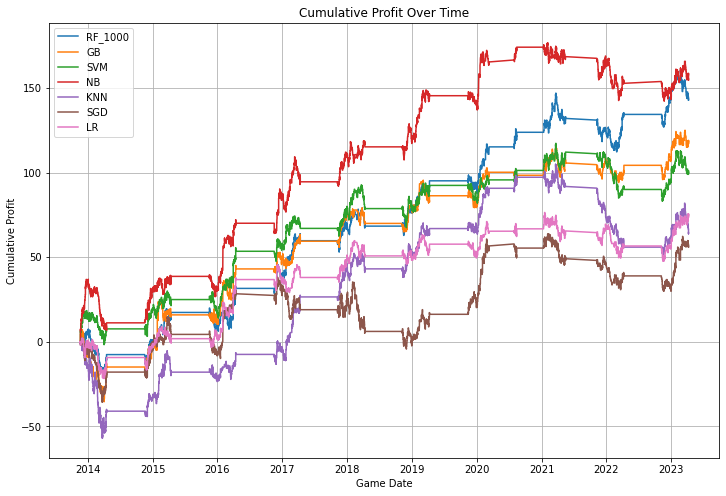

In [265]:
plt.figure(figsize=(12, 8))

for model in models:
    model_abbv = model["abbreviation"]
    plt.plot(main_df['GAME_DATE'], main_df[f"{model_abbv}_PROFIT_TRACKING"], label = model_abbv)
    
plt.title('Cumulative Profit Over Time')
plt.xlabel('Game Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.show()